In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
import os
from functools import partial
from pathlib import Path

import pandas as pd
from openai import OpenAI

from bellek.utils import jprint
from bellek.utils import set_seed

set_seed(42)

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

## Dataset

In [ ]:
df = pd.read_json('../../data/generated/musique-evaluation/dataset.jsonl', orient='records', lines=True)
qd_df = pd.read_json('../../data/generated/musique-evaluation/question-decomposition.jsonl', orient='records', lines=True)
df = pd.merge(df.drop(columns=['question', 'question_decomposition']), qd_df, on='id', suffixes=('', ''))
print(len(df))
df.head()

1252


,id,paragraphs,answer,answer_aliases,answerable,answers,question,question_decomposition
0,2hop__131818_161450,"[{'idx': 0, 'title': 'Maria Carrillo High Scho...",in the north-east of the country south of the ...,"[Caspian Sea, in the north-east of the country...",True,"[Caspian Sea, in the north-east of the country...",Where is the Voshmgir District located?,"[{'id': 131818, 'question': 'In which province..."
1,2hop__444265_82341,"[{'idx': 0, 'title': 'Ocala, Florida', 'paragr...",in Northern Florida,"[in Northern Florida, Northern Florida]",True,"[in Northern Florida, Northern Florida]",In what part of Florida is Tom Denney's birthp...,"[{'id': 444265, 'question': 'Where was Tom Den..."
2,2hop__711946_269414,"[{'idx': 0, 'title': 'Wild Thing (Tone Lōc son...",Kill Rock Stars,[Kill Rock Stars],True,[Kill Rock Stars],What record label is the performer who release...,"[{'id': 711946, 'question': 'Who released All ..."
3,2hop__311931_417706,"[{'idx': 0, 'title': 'The Main Attraction (alb...",Attic Records,"[Attic, Attic Records]",True,"[Attic, Attic Records]",What record label does the performer of Emotio...,"[{'id': 311931, 'question': 'Who is the perfor..."
4,2hop__809785_606637,"[{'idx': 0, 'title': 'The Main Attraction (alb...",Secret City Records,[Secret City Records],True,[Secret City Records],What record label does the performer of Advent...,"[{'id': 809785, 'question': 'Who is the perfor..."


In [ ]:
jerx_file = Path("../../data/raw/musique-evaluation/jerx-inferences/llama3-base.jsonl")
jerx_df = pd.read_json(jerx_file, lines=True)
print(len(jerx_df))
jerx_df.head()

25038


,id,paragraph_idx,paragraph_text,paragraph_title,is_supporting,text,input,generation
0,2hop__131818_161450,0,Maria Carrillo High School is a public high sc...,Maria Carrillo High School,False,# Maria Carrillo High School\nMaria Carrillo H...,[{'content': 'You are an excellent knowledge g...,Maria Carrillo High School | location | Santa ...
1,2hop__131818_161450,1,"Golestān Province (Persian: استان گلستان‎, Ost...",Golestan Province,True,# Golestan Province\nGolestān Province (Persia...,[{'content': 'You are an excellent knowledge g...,Golestan Province | location | north-east of I...
2,2hop__131818_161450,2,Voshmgir District () is a district (bakhsh) in...,Voshmgir District,True,# Voshmgir District\nVoshmgir District () is a...,[{'content': 'You are an excellent knowledge g...,"Voshmgir District | location | Aqqala County, ..."
3,2hop__131818_161450,3,52 Heroor is a village in the southern state o...,52 Heroor,False,# 52 Heroor\n52 Heroor is a village in the sou...,[{'content': 'You are an excellent knowledge g...,"52 Heroor | location | Karnataka, India\n52 He..."
4,2hop__131818_161450,4,Vennaimalai is a village of Karur District loc...,Vennaimalai,False,# Vennaimalai\nVennaimalai is a village of Kar...,[{'content': 'You are an excellent knowledge g...,Vennaimalai | location | Karur District\nVenna...


In [ ]:
jerx_mapping = {(row['id'], row['paragraph_idx']): row['generation'] for _, row in jerx_df.iterrows()}

def extract_triplets(example: dict):
    example["triplets_str"] = [jerx_mapping[(example['id'], p['idx'])].strip() for p in example['paragraphs']]
    return example

In [ ]:
df = df.apply(extract_triplets, axis=1)
df.head()

,id,paragraphs,answer,answer_aliases,answerable,answers,question,question_decomposition,triplets_str
0,2hop__131818_161450,"[{'idx': 0, 'title': 'Maria Carrillo High Scho...",in the north-east of the country south of the ...,"[Caspian Sea, in the north-east of the country...",True,"[Caspian Sea, in the north-east of the country...",Where is the Voshmgir District located?,"[{'id': 131818, 'question': 'In which province...",[Maria Carrillo High School | location | Santa...
1,2hop__444265_82341,"[{'idx': 0, 'title': 'Ocala, Florida', 'paragr...",in Northern Florida,"[in Northern Florida, Northern Florida]",True,"[in Northern Florida, Northern Florida]",In what part of Florida is Tom Denney's birthp...,"[{'id': 444265, 'question': 'Where was Tom Den...",[Ocala | location | Florida\nOcala | location ...
2,2hop__711946_269414,"[{'idx': 0, 'title': 'Wild Thing (Tone Lōc son...",Kill Rock Stars,[Kill Rock Stars],True,[Kill Rock Stars],What record label is the performer who release...,"[{'id': 711946, 'question': 'Who released All ...",[Wild Thing | song by | Tone Lōc\nWild Thing |...
3,2hop__311931_417706,"[{'idx': 0, 'title': 'The Main Attraction (alb...",Attic Records,"[Attic, Attic Records]",True,"[Attic, Attic Records]",What record label does the performer of Emotio...,"[{'id': 311931, 'question': 'Who is the perfor...",[The Main Attraction | type | album\nThe Main ...
4,2hop__809785_606637,"[{'idx': 0, 'title': 'The Main Attraction (alb...",Secret City Records,[Secret City Records],True,[Secret City Records],What record label does the performer of Advent...,"[{'id': 809785, 'question': 'Who is the perfor...",[The Main Attraction (album) | artist | Grant ...


In [ ]:
i = 1
row = df.iloc[i]
row

id                                                       2hop__444265_82341
paragraphs                [{'idx': 0, 'title': 'Ocala, Florida', 'paragr...
answer                                                  in Northern Florida
answer_aliases                      [in Northern Florida, Northern Florida]
answerable                                                             True
answers                             [in Northern Florida, Northern Florida]
question                  In what part of Florida is Tom Denney's birthp...
question_decomposition    [{'id': 444265, 'question': 'Where was Tom Den...
triplets_str              [Ocala | location | Florida\nOcala | location ...
Name: 1, dtype: object

In [ ]:
for triplets in row['triplets_str']:
    print(triplets) 
    print("="*80)

Ocala | location | Florida
Ocala | location type | Northern Florida
Ocala | population | 57,468
Ocala | ranking | 45th (most populated city in Florida)
Jasmine Estates | location | Pasco County, Florida
Jasmine Estates | type | Census-designated place
Jasmine Estates | population | 18,989
Jasmine Estates | census year | 2010
Ridgecrest | location | Pinellas County, Florida, United States
Ridgecrest | type | Census-designated place (CDP)
Ridgecrest | population | 2,558 (2010 census)
Villas | location | Lee County, Florida
Villas | type | census designated place (CDP)
Villas | population | 11,346
Villas | part of | Cape Coral-Fort Myers, Florida Metropolitan Statistical Area
Lacoochee | location | Pasco County, Florida, United States
Lacoochee | population | 1345
Lacoochee | type | Census-designated place (CDP)
Solana, Florida | location | Charlotte County, Florida, United States
Solana, Florida | type | Unincorporated community and census-designated place
Solana, Florida | population | 

In [ ]:
print(row['question'])

In what part of Florida is Tom Denney's birthplace located?


In [ ]:
print(row['question_decomposition'][0]['question'])
print(row['question_decomposition'][1]['question'])

Where was Tom Denney born?
In what part of Florida is #1 located?


In [ ]:
row['question_decomposition'][0]

{'id': 444265,
 'question': 'Where was Tom Denney born?',
 'answer': 'Ocala',
 'paragraph_support_idx': 12}

## Search

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

def search(docs: list[dict], query: str, top_k: int = 3):
    embeddings = model.encode([doc['text'] for doc in docs])
    query_vectors = model.encode([query])
    similarities = model.similarity(embeddings, query_vectors)
    sorted_indices = similarities.argsort(dim=0, descending=True)
    return [docs[i] for i in sorted_indices[:top_k]]

/Users/bdsaglam/dev/repos/bellek/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
docs = [{'text': p['paragraph_text'], **p} for p in row['paragraphs']]
print(docs[0]['text'])

Ocala (/ oʊ ˈkælə / oh - KAL - ə) is a city located in Northern Florida. As of the 2013 census, its population, estimated by the United States Census Bureau, was 57,468, making it the 45th most populated city in Florida.


In [ ]:
question = row['question_decomposition'][0]['question']
question

'Where was Tom Denney born?'

In [ ]:
search(docs, question, top_k=3)

[{'text': 'Tom Denney (born November 23, 1982) is an American musician from Ocala, Florida. Denney is a founding member and the ex-lead guitarist of A Day to Remember. He has since parted ways with the band and now produces at his own recording studio.',
  'idx': 12,
  'title': 'Tom Denney',
  'paragraph_text': 'Tom Denney (born November 23, 1982) is an American musician from Ocala, Florida. Denney is a founding member and the ex-lead guitarist of A Day to Remember. He has since parted ways with the band and now produces at his own recording studio.',
  'is_supporting': True},
 {'text': 'Tom Edward Hammonds (born March 27, 1967) is a retired American professional basketball player and National Hot Rod Association drag racer. He was born in Fort Walton Beach, Florida, and attended Crestview High School in Crestview, Florida.',
  'idx': 18,
  'title': 'Tom Hammonds',
  'paragraph_text': 'Tom Edward Hammonds (born March 27, 1967) is a retired American professional basketball player and Na

In [ ]:
def retrieval(row):
    docs = [{'text': p['paragraph_text'], **p} for p in row['paragraphs']]
    query1 = row['question_decomposition'][0]['question']
    query2 = row['question_decomposition'][1]['question'].replace("#1", row['question_decomposition'][0]['answer'])
    for i, qd, query  in zip(range(1,3), row['question_decomposition'], [query1, query2]):
        results = search(docs, query, top_k = len(row['paragraphs']))
        retrieved_docs_ids = [result['idx'] for result in results]
        row[f'target_doc_idx_{i}'] = qd['paragraph_support_idx']
        row[f'retrieved_doc_ids_{i}'] = retrieved_docs_ids
        row[f'target_retrieval_pos_{i}'] = retrieved_docs_ids.index(qd['paragraph_support_idx'])
    return row

In [ ]:
df = df.progress_apply(retrieval, axis=1)

  0%|          | 0/1252 [00:00<?, ?it/s]

In [ ]:
df.head()

,id,paragraphs,answer,answer_aliases,answerable,answers,question,question_decomposition,triplets_str,target_doc_idx_1,retrieved_doc_ids_1,target_retrieval_pos_1,target_doc_idx_2,retrieved_doc_ids_2,target_retrieval_pos_2
0,2hop__131818_161450,"[{'idx': 0, 'title': 'Maria Carrillo High Scho...",in the north-east of the country south of the ...,"[Caspian Sea, in the north-east of the country...",True,"[Caspian Sea, in the north-east of the country...",Where is the Voshmgir District located?,"[{'id': 131818, 'question': 'In which province...",[Maria Carrillo High School | location | Santa...,2,"[2, 19, 16, 1, 18, 5, 7, 3, 15, 14, 4, 17, 6, ...",0,1,"[1, 2, 4, 14, 5, 16, 19, 6, 9, 8, 7, 3, 10, 18...",0
1,2hop__444265_82341,"[{'idx': 0, 'title': 'Ocala, Florida', 'paragr...",in Northern Florida,"[in Northern Florida, Northern Florida]",True,"[in Northern Florida, Northern Florida]",In what part of Florida is Tom Denney's birthp...,"[{'id': 444265, 'question': 'Where was Tom Den...",[Ocala | location | Florida\nOcala | location ...,12,"[12, 18, 2, 5, 14, 6, 11, 9, 17, 16, 7, 10, 19...",0,0,"[0, 1, 9, 2, 15, 4, 6, 19, 14, 10, 7, 11, 3, 1...",0
2,2hop__711946_269414,"[{'idx': 0, 'title': 'Wild Thing (Tone Lōc son...",Kill Rock Stars,[Kill Rock Stars],True,[Kill Rock Stars],What record label is the performer who release...,"[{'id': 711946, 'question': 'Who released All ...",[Wild Thing | song by | Tone Lōc\nWild Thing |...,3,"[3, 0, 8, 10, 17, 19, 18, 13, 5, 15, 1, 2, 14,...",0,4,"[4, 3, 19, 6, 7, 15, 1, 10, 18, 12, 5, 13, 17,...",0
3,2hop__311931_417706,"[{'idx': 0, 'title': 'The Main Attraction (alb...",Attic Records,"[Attic, Attic Records]",True,"[Attic, Attic Records]",What record label does the performer of Emotio...,"[{'id': 311931, 'question': 'Who is the perfor...",[The Main Attraction | type | album\nThe Main ...,10,"[10, 1, 16, 18, 19, 9, 0, 14, 6, 7, 17, 4, 11,...",0,8,"[8, 10, 11, 12, 15, 4, 5, 13, 14, 17, 7, 9, 0,...",0
4,2hop__809785_606637,"[{'idx': 0, 'title': 'The Main Attraction (alb...",Secret City Records,[Secret City Records],True,[Secret City Records],What record label does the performer of Advent...,"[{'id': 809785, 'question': 'Who is the perfor...",[The Main Attraction (album) | artist | Grant ...,15,"[15, 14, 3, 16, 0, 2, 6, 17, 13, 9, 18, 19, 5,...",0,18,"[15, 18, 9, 4, 19, 6, 1, 5, 2, 13, 12, 3, 10, ...",1


In [ ]:
df[['target_retrieval_pos_1', 'target_retrieval_pos_2']].describe(percentiles=[.5, .75, .9, .95])

,target_retrieval_pos_1,target_retrieval_pos_2
count,1252.000000,1252.000000
mean,1.144569,0.990415
std,2.992241,2.379617
min,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
90%,4.000000,3.000000
95%,7.000000,6.000000
max,19.000000,19.000000


<Axes: >

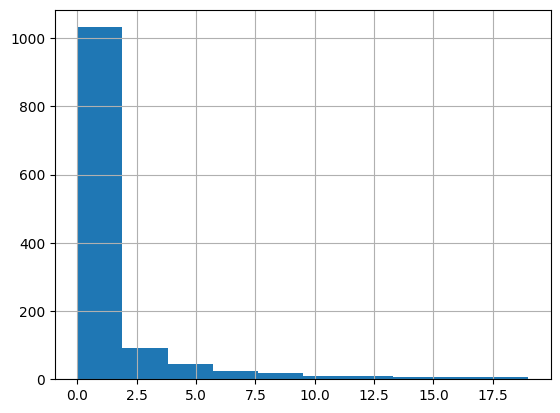

In [ ]:
df['target_retrieval_pos_1'].hist()

<Axes: >

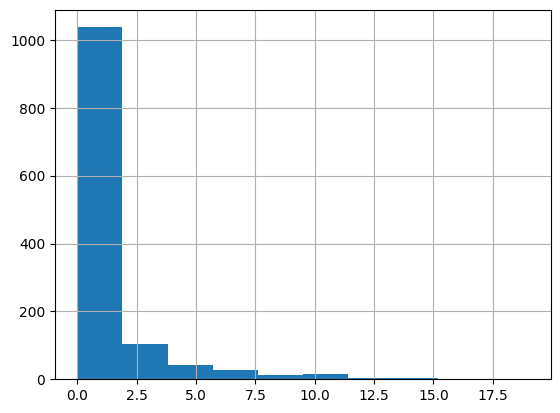

In [ ]:
df['target_retrieval_pos_2'].hist()